In [1]:
import tensorflow as tf
print(tf.__version__)
print(len(tf.config.list_physical_devices('GPU'))>0)

2.10.0
True


In [2]:
import numpy as np 
import pandas as pd

In [3]:
summary = pd.read_csv('news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
pre1 =  raw.iloc[:,0:2].copy()
# pre1['head + text'] = pre1['headlines'].str.cat(pre1['text'], sep =" ") 

pre2 = summary.iloc[:,0:6].copy()
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

In [5]:
pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'],pre2['headlines']],ignore_index = True)

In [6]:
pre.head(5)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


In [7]:
pre['text'][:10]

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
5    Pakistani singer Rahat Fateh Ali Khan has deni...
6    India recorded their lowest ODI total in New Z...
7    Weeks after ex-CBI Director Alok Verma told th...
8    Andhra Pradesh CM N Chandrababu Naidu has said...
9    Congress candidate Shafia Zubair won the Ramga...
Name: text, dtype: object

### Performing Data Cleaning

In [8]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row

In [9]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['summary'])

In [10]:
from time import time
import spacy
nlp = spacy.load(r'C:\Users\meghc\miniconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-3.4.1', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
#If data loss seems to be happening(i.e len(text) = 50 instead of 75 etc etc) in this cell , decrease the batch_size parametre 

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

C:\Users\meghc\miniconda3\envs\tensorflow\lib\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value ['ner', 'parser'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


Time to clean up everything: 8.37 mins


In [11]:
# import spacy
# nlp = spacy.load(r'C:\Users\meghc\miniconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-3.4.1')

In [12]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.31 mins


In [13]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [14]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [15]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

In [16]:
text_count = []
summary_count = []

In [17]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [18]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

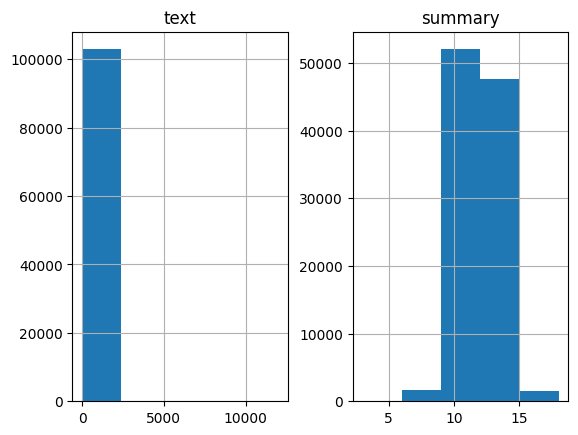

In [19]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [20]:
#Check how much % of summary have 0-15 words
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.9978234465335472


In [21]:
#Check how much % of text have 0-100 words
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

0.9578389933440218


In [22]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15

In [23]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [24]:
post_pre.head(10)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...
2,new zealand defeated india by wickets in the f...,_START_ new zealand end rohit sharma-led india...
3,with aegon life iterm insurance plan customers...,_START_ aegon life iterm insurance plan helps ...
4,speaking about the sexual harassment allegatio...,_START_ have known hirani for yrs what if meto...
5,pakistani singer rahat fateh ali khan has deni...,_START_ rahat fateh ali khan denies getting no...
6,india recorded their lowest odi total in new z...,_START_ india get all out for 92 their lowest ...
7,weeks after ex-cbi director alok verma told th...,_START_ govt directs alok verma to join work d...
8,andhra pradesh cm chandrababu naidu has said w...,_START_ called pm modi sir 10 times to satisfy...
9,congress candidate shafia zubair won the ramga...,_START_ cong wins ramgarh bypoll in rajasthan ...


In [25]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [26]:
post_pre.head(10)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...
2,new zealand defeated india by wickets in the f...,sostok _START_ new zealand end rohit sharma-le...
3,with aegon life iterm insurance plan customers...,sostok _START_ aegon life iterm insurance plan...
4,speaking about the sexual harassment allegatio...,sostok _START_ have known hirani for yrs what ...
5,pakistani singer rahat fateh ali khan has deni...,sostok _START_ rahat fateh ali khan denies get...
6,india recorded their lowest odi total in new z...,sostok _START_ india get all out for 92 their ...
7,weeks after ex-cbi director alok verma told th...,sostok _START_ govt directs alok verma to join...
8,andhra pradesh cm chandrababu naidu has said w...,sostok _START_ called pm modi sir 10 times to ...
9,congress candidate shafia zubair won the ramga...,sostok _START_ cong wins ramgarh bypoll in raj...


### Seq2Seq model

In [27]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val = train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [28]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [29]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


% of rare words in vocabulary: 57.91270391131826
Total Coverage of rare words: 1.3404923996005096


In [30]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 33412


In [31]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [32]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.34503603813067
Total Coverage of rare words: 3.566630093901333


In [33]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 11581


In [34]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [35]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [36]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 33412
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     6682400     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

### Fitting the model 

In [39]:
history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
692/692 [==============================] - 1957s 3s/step - loss: 5.1227 - val_loss: 4.7974
Epoch 2/10
692/692 [==============================] - 2033s 3s/step - loss: 4.7253 - val_loss: 4.5512
Epoch 3/10
692/692 [==============================] - 2083s 3s/step - loss: 4.4766 - val_loss: 4.3311
Epoch 4/10
692/692 [==============================] - 2077s 3s/step - loss: 4.2534 - val_loss: 4.1412
Epoch 5/10
692/692 [==============================] - 2091s 3s/step - loss: 4.0653 - val_loss: 3.9977
Epoch 6/10
692/692 [==============================] - 2104s 3s/step - loss: 3.9165 - val_loss: 3.8750
Epoch 7/10
692/692 [==============================] - 2069s 3s/step - loss: 3.7960 - val_loss: 3.7818
Epoch 8/10
692/692 [==============================] - 2055s 3s/step - loss: 3.6905 - val_loss: 3.7101
Epoch 9/10
692/692 [==============================] - 2047s 3s/step - loss: 3.5991 - val_loss: 3.6430
Epoch 10/10
692/692 [==============================] - 2048s 3s/step - loss: 3.519

In [40]:
model.save("model")

INFO:tensorflow:Assets written to: model\assets


In [41]:
model.save("seq_model.h5")

### Visualize the model learning

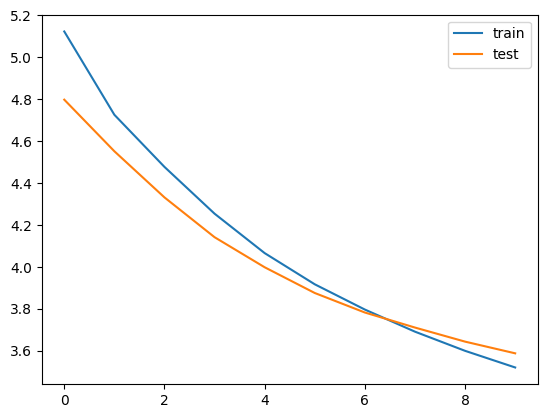

In [42]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [44]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [45]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### We are defining a function below which is the implementation of the inference process

In [46]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

### Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [47]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

### Run the model over the data to see the results

In [48]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: pope francis on tuesday called for respect for each ethnic group in speech delivered in myanmar avoiding reference to the rohingya minority community as the nation works to restore peace the healing of wounds must be priority he said the pope myanmar visit comes amid the country military crackdown resulting in the rohingya refugee crisis 
Original summary: start pope avoids mention of rohingyas in key myanmar speech end 
1/1 [==============================] - 0s 34ms/step
Predicted summary:  start un calls un calls for rohingya muslims end


Review: students of government school in uttar pradesh sambhal were seen washing dishes at in school premises on being approached basic shiksha adhikari virendra pratap singh said yes have also received this complaint from elsewhere we are inquiring and action will be taken against those found guilty 
Original summary: start students seen washing dishes at govt school in up end 
1/1 [==============================] - 0s 31ms/step
Predicted 

1/1 [==============================] - 0s 32ms/step
Predicted summary:  start pm modi meets indian pm modi in china end


Review: external affairs minister sushma swaraj on saturday called upon the united nations to pass the comprehensive convention on international terrorism to end pakistan sponsored terrorism proposed by india in 1996 aims to arrive at universal definition of terrorism ban all terror groups prosecute terrorists under special laws and make cross border terrorism an offence 
Original summary: start india calls on un to pass global anti terror convention end 
1/1 [==============================] - 0s 27ms/step
Predicted summary:  start india to be part of war with pak army chief end


Review: the 23 richest indians in the 500 member bloomberg billionaires index saw wealth erosion of 21 billion this year lakshmi mittal who controls the world largest steelmaker arcelormittal lost 5 6 billion or 29 of his net worth followed by sun pharma founder dilip shanghvi whose wealth

1/1 [==============================] - 0s 16ms/step
Predicted summary:  start icc to play cricket in cricket cricket end


Review: a case has been registered against raja chauhan for firing gunshots in violence during bharat bandh called by dalit groups in madhya pradesh gwalior on monday video showing chauhan alleged to be bjp worker firing during the protest had surfaced online of the 12 people killed during the nationwide protests at least three were from gwalior 
Original summary: start case filed man who fired in dalit protests end 
1/1 [==============================] - 0s 16ms/step
Predicted summary:  start 2 held for posting pics of bjp leader in karnataka end


Review: there are believed to be 80 different ways to spell the name of english playwright william shakespeare including and shakespeare is known to have signed his name using variations such as and due to no proper documentation april 23 is regarded as his birth date and april 23 as his death date 
Original summary: st

1/1 [==============================] - 0s 31ms/step
Predicted summary:  start indian origin woman shot dead in us end


Review: a 64 year old father and his 35 year old daughter flew their last flight together as british airways pilots on thursday david said he felt mixed emotions at retiring and was glad his daughter kat would continue their legacy the two had flown together numerous times and kat said she believed their father daughter bond helped them in the cockpit 
Original summary: start father and daughter fly last flight together as ba pilots end 
1/1 [==============================] - 0s 16ms/step
Predicted summary:  start indian origin man who died in flight after years end


Review: pakistan chief selector inzamam ul haq nephew imam ul haq collided with wicketkeeper brien and kane while completing single off ireland first ever test delivery on saturday debutant imam fell flat on his back after his head into brien hip while trying to make his crease uncle would ve just both f

1/1 [==============================] - 0s 33ms/step
Predicted summary:  start trump kim jong un will be part of war un end


Review: actress yami gautam has said rajkummar rao would have been amazing as the lead character vicky in the 2012 film vicky donor the character was originally portrayed by ayushmann khurrana who made his bollywood debut in the film while yami played the female lead when asked who would have played yami character well ayushmann had earlier taken bhumi pednekar name 
Original summary: start rajkummar would have been amazing as vicky in vicky donor yami end 
1/1 [==============================] - 0s 15ms/step
Predicted summary:  start i am not to play in film with rajkummar rao end


Review: an east german secret police identity card belonging to russian president vladimir putin when he was soviet spy has been found in police archives in the city of dresden the card was issued in 1985 when putin was mid ranking soviet spy stationed in dresden in communist east ger

1/1 [==============================] - 0s 31ms/step
Predicted summary:  start new york city to be auctioned for the first time end


Review: the us has accused china of pointing military grade blinding lasers at its pilots in djibouti in nearly 10 such incidents in the past few weeks two us military pilots suffered minor eye injuries in one case officials said while the us has military base in djibouti since 2001 china opened its first overseas base in the region last year 
Original summary: start us accuses china of lasers at its pilots eyes end 
1/1 [==============================] - 0s 31ms/step
Predicted summary:  start us military military kills us in afghanistan end


Review: a fake news update is being shared on whatsapp which claims that the government provides compensation in case of death due to accident it claims that if person dies in an accident and has been filing his income tax since the last three years the government will provide compensation equivalent to 10 times his

1/1 [==============================] - 0s 16ms/step
Predicted summary:  start kohli to be paid for the ipl 2018 coach end


Review: singer ariana grande visited young children in hospital who were injured after blast at her concert in manchester uk in may the 23 year old singer presented t shirts and gifts to the young children ariana along with justin bieber miley cyrus and coldplay will perform on june to raise funds for the victims of the terrorist attack at the concert 
Original summary: start ariana grande visits kids injured after blast at her concert end 
1/1 [==============================] - 0s 35ms/step
Predicted summary:  start singer who died passes away aged aged 77 end


Review: a former uber manager robert miller had reportedly warned uberã¢ââs executives about safety issues before the fatal self driving car crash in arizona in march ã¢ââthe cars are routinely in accidents resulting in damage this is not how we should be operating ã¢ââ miller had said he added ã¢â

1/1 [==============================] - 0s 31ms/step
Predicted summary:  start i am not the film of the film industry end


Review: a new trailer of the hindi version of deadpool has been released where ranveer singh is seen voicing ryan reynolds who plays the lead role of deadpool bollywood desi cool is india deadpool tweeted fox star india the distributors of the film in india earlier another trailer had been released which featured different voice artiste 
Original summary: start ranveer singh voices reynolds in deadpool hindi version end 
1/1 [==============================] - 0s 33ms/step
Predicted summary:  start trailer of the film released end


Review: the archaeological survey of india asi has banned selfie sticks at its 46 site museums across the country including taj museum in agra and indian war memorial museum in delhi further the visitors would need to get permission for using flash multiple lenses and carrying large photography bags 15 days before the scheduled visit 
Or

1/1 [==============================] - 0s 31ms/step
Predicted summary:  start bjp candidate wins contest polls for 1st time in gujarat end


Review: kartik aaryan is coming today for live interactive session on huawei mate 20 pro touted in media reports as the king of smartphones at ambience mall gurugram pm onwards first buyer will get chance to the smartphone with kartik as while the next will get to take group selfie with him 
Original summary: start kartik aaryan comes to flag off offline strategy end 
1/1 [==============================] - 0s 16ms/step
Predicted summary:  start song from the new york released end


Review: days after bjp and its allies sealed seat sharing arrangement in bihar ahead of 2019 lok sabha polls bjp mp gopal narayan singh said like all over india in bihar also our main brand is pm narendra modiji claiming both jd and bjp are equal partners singh added if bjp needs cm nitish kumar then he also needs bjp 
Original summary: start pm modi is our main brand i

1/1 [==============================] - 0s 16ms/step
Predicted summary:  start air india flight to be auctioned for flight end


Review: the bombay high court on monday accepted maharashtra government proposal that it wouldn allow children below 14 years of age to participate in the dahi handi festival which witnesses several injuries to youngsters however the bench refused to impose any restriction on the height of human pyramid formations during the festival notably since 2014 children below 18 years weren allowed 
Original summary: start hc accepts maha govt 14 yrs age restriction for dahi handi end 
1/1 [==============================] - 0s 26ms/step
Predicted summary:  start delhi hc orders ban on liquor ban end


Review: the rajasthan high court has issued notice to the centre asking why condom advertisements cannot be shown on tv between am and 10 pm the court was hearing petition filed by nonprofit organisation which has called the order arbitrary and meaningless earlier this mo

1/1 [==============================] - 0s 31ms/step
Predicted summary:  start i am not the nobel prize for the year end


Review: reacting to kylie jenner naming her baby stormi webster twitter user wrote if ever have child ll be naming it north chicago storm weather forecast commented another user while referring to north and chicago the daughters of kylie half sister kim kardashian another tweet read it wasn going to be called something boring like brenda 
Original summary: start will name kid tweets user on kylie naming kid end 
1/1 [==============================] - 0s 31ms/step
Predicted summary:  start i am the right to be auctioned for me end


Review: the union home ministry has warned that threat to prime minister narendra modi is at an all time high the home ministry has laid down security protocol which includes even ministers and officers to be cleared by special protection group spg staff before they can come close to pm modi this comes after maharashtra police seized docu

1/1 [==============================] - 0s 14ms/step
Predicted summary:  start pm modi calls for ceasefire in pak end


Review: nagaland under 19 girls team was dismissed for two runs in 17 overs while playing against kerala in the ongoing bcci women under 19 one day league on friday nagaland opener top scored for the team with run while the other run came off an extra kerala hit boundary on the first ball winning with 299 balls to spare 
Original summary: start nagaland team all out for runs rivals win on 1st ball end 
1/1 [==============================] - 0s 31ms/step
Predicted summary:  start 3 yr old indian player gets out for ipl match end


Review: the cemetery in city slovenia has unveiled tombstones with 48 inch interactive screens that can show pictures videos and other digital content the company claims the tombstones are weather proof and cannot be vandalised the tombstones which cost ã¢ââ¬3 000 ã¢ââ¹2 lakh each activate their sensors when someone stands near them 
Origina

1/1 [==============================] - 0s 28ms/step
Predicted summary:  start man city wins for the first time in the year end


Review: former apple executive neha rastogi who accused her husband and ceo abhishek gattani of domestic abuse has disclosed audio recordings of gattani abusing and beating her in court statement rastogi said he hit me multiple times on my face arms head belly and abused me gattani was allowed plea agreement and faces 30 days in jail 
Original summary: start ex apple engineer says husband abused hit her several times end 
1/1 [==============================] - 0s 25ms/step
Predicted summary:  start apple ceo responds to ex girlfriend end


Review: former ufc fighter tim hague has passed away aged 34 after suffering knockout in boxing fight the canadian mixed martial artist was taken to hospital on friday after being knocked out by adam but died on sunday hague fought 34 mixed martial arts contests in his career including five ufc fights and held an overall 21

1/1 [==============================] - 0s 34ms/step
Predicted summary:  start samsung unveils electric car car to sell cars end


Review: the hearing to decide the quantum of punishment to dera chief gurmeet ram rahim singh will take place through video conferencing on august 28 panchkula cbi court had convicted singh on charges of rape on friday as per reports the punishment can be jail term not less than seven years but may even extend to life imprisonment 
Original summary: start ram rahim to get rape punishment through video conference end 
1/1 [==============================] - 0s 38ms/step
Predicted summary:  start ram rahim to be given into ram rahim end


Review: us defence research agency darpa has launched persistent aquatic living sensors program that will study the viability of using both natural and modified sea organisms to detect underwater vehicles the system would aim to translate the biological responses of sea life into usable data to warn ships without needing hardw